In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys, re, math, random
import xml.etree.ElementTree as ET
from rules import *
from predict import *
from raven_data import load_question, display_problem
from tqdm.notebook import tqdm

['constant', 'progression', 'arithmetic', 'distribute_three', 'noise']


  0%|          | 0/1 [00:00<?, ?it/s]

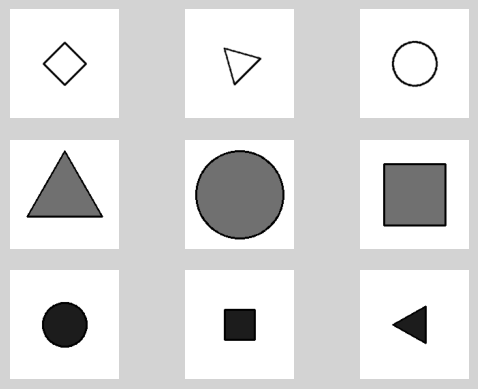

Correct answer: 1


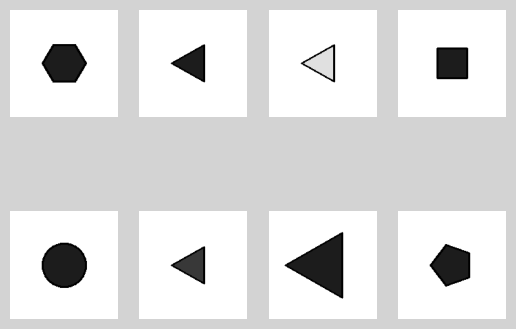

[[0, 0, 2, 0, 0, 4, 1, 1], [0, 1, 1, 0, 0, 4, 1, 1], [0, 2, 5, 0, 0, 4, 1, 1]]
[[1, 0, 1, 4, 5, 3, 1, 1], [1, 1, 5, 4, 5, 3, 1, 1], [1, 2, 2, 4, 5, 3, 1, 1]]
[[2, 0, 5, 0, 8, 5, 1, 1], [2, 1, 2, 0, 8, 5, 1, 1], None]
Attribute 2 Type follows rule 3 distribute_three SINGLE
Attribute 3 Size follows rule 0 constant SINGLE
Attribute 4 Color follows rule 0 constant SINGLE
Attribute 5 Angle follows rule 0 constant SINGLE
Attribute 6 BWPosition follows rule 0 constant SINGLE
Attribute 7 Number follows rule 0 constant SINGLE
Guess 0 failed rule distribute_three for attribute 2 Type
My guess is 1 with embedding [2, 2, 1, 0, 8, 5, 1, 1]
Guess 2 failed rule constant for attribute 4 Color
Guess 3 failed rule distribute_three for attribute 2 Type
Guess 4 failed rule distribute_three for attribute 2 Type
Guess 5 failed rule constant for attribute 4 Color
Guess 6 failed rule constant for attribute 3 Size
Guess 7 failed rule distribute_three for attribute 2 Type
Guessed orrect answer 1 [2, 2, 1, 0, 8,

In [3]:
# Generalized components v1: 3.5s / 63.6s
path = '../RAVEN/new_data_0'
subtype = '*'
items = sorted([x.split('.xml')[0] for x in glob.glob(os.path.join(path, subtype, '*.xml'))])
# print(items)
correct = 0
debug=True
global_counts = [0 for _ in rule_order]
if debug:
    items=['../RAVEN/new_data_0/center_single/RAVEN_15_train']
for index, item in tqdm(enumerate(items), total=len(items)):
    embeddings, embedding_names, answer = load_question(item, display=debug, debug=False)
    if any(len(embedding) != len(embeddings[0]) for embedding in embeddings):
        print("Error!", item, " has embeddings of different lengths")
        break
    guess, counts, _ = predict(embeddings,embedding_names,debug=debug)
    global_counts = [global_counts[i] + counts[i] for i in range(5)]
    if guess == answer:
        correct += 1
        if debug:
            print("Guessed orrect answer", answer, embeddings[8+answer])
    else:
        if debug:
            grid = [[0, 1, 2], [3, 4, 5], [6, 7, None]]
            print("\n".join([str([embeddings[col] if col is not None else None for col in row ]) for row in grid]))
            print("Answer", answer, embeddings[8+answer], "Guess", guess, embeddings[8+guess] if guess is not None else None)
        print("WRONG",item, "Wrong guess", guess, "Correct answer", answer)
print("Names of rules:", [rule.__name__ for rule in rule_order])
print("Counts", global_counts)
print("Percentages", [global_counts[i]/sum(global_counts) for i in range(5)])

In [3]:
rule = rule_order[9]
print(rule.__name__, rule)
rule_size = rule(3)
print(rule_size.__name__, rule_size)
datapoint = [[[0, 0, 3, 1, 9, 3, 1, 1], [0, 1, 3, 3, 8, 3, 1, 1], [0, 2, 3, 5, 7, 3, 1, 1]],
[[1, 0, 1, 1, 5, 0, 1, 1], [1, 1, 1, 3, 4, 0, 1, 1], [1, 2, 1, 5, 3, 0, 1, 1]]]
res = rule_size(datapoint)
print(res)
# res(datapoint)

IndexError: list index out of range

In [3]:
from collections import defaultdict
unique_value_count = defaultdict(lambda: defaultdict(int))
# unique_value_count = [defaultdict(int) for _ in range(20)]
largest = []
for item in items:
    embeddings, embedding_names, answer = load_question(item, display=False)
    for embedding in embeddings:
        for name, value in zip(embedding_names, embedding):
            if value is not None:
                unique_value_count[name][value] += 1
    if len(embedding_names) > len(largest):
        largest = embedding_names
print("Unique values")
for name, values in unique_value_count.items():
    print(name, sorted(list(values.keys())))

Unique values
Row [0, 1, 2]
Col [0, 1, 2]
Type [1, 2, 3, 4, 5]
Size [0, 1, 2, 3, 4, 5]
Color [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Angle [0, 1, 2, 3, 4, 5, 6, 7]
BWPosition [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 58, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 80, 81, 82, 83, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 108, 109, 110, 111, 112, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 148, 151, 152, 154, 158, 159, 160, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 186, 188, 189, 190, 191, 192, 194, 196, 197, 199, 200, 202, 203, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 217, 218, 219, 223, 224, 228, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 24